In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
sudo apt-get update
sudo apt-get install -y --no-install-recommends \
    build-essential cmake git wget \
    libboost-all-dev libeigen3-dev libsuitesparse-dev \
    python3-dev python3-pip

python3 -m pip install --user pybind11

python3 -m pip install --user slepc4py
"""

In [21]:
fenics.__file__

'/usr/local/lib/python3.11/dist-packages/fenics/__init__.py'

| Parameter    | Units                 | Physical Role                                        |
|--------------|-----------------------|------------------------------------------------------|
| $$ \mu $$    | Pa·s                  | Dynamic viscosity of blood                           |
| $$ k_t $$    | $$ \text{m}^2 $$      | 3D tissue permeability                               |
| $$ k_v $$    | $$ \text{m}^2 $$      | Axial permeability along the vessel                  |
| $$ \gamma $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Vessel wall permeability coefficient (coupling tissue & vessel) |
| $$ \gamma_R $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Boundary outflow (Robin) permeability                 |
| $$ \gamma_a $$ | m                    | Terminal vessel coupling length scale (hydraulic conductance at end) |

In [ ]:
# @title Install nonstandard libraries
%%capture
!pip install ipywidgets
!pip install vtk
!pip install meshio
!pip install pyvista
!pip install Rtree

import os, re

def replace_in_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Replace 'ufl' with 'ufl_legacy'
    content = re.sub(r'\bufl\b', 'ufl_legacy', content)

    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(content)

def process_directory(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.py'):
                file_path = os.path.join(root, file)
                replace_in_file(file_path)

# dolfin
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"

# block
try:
    import block
except ImportError:
    !git clone "https://bitbucket.org/fenics-apps/cbc.block/src/master/"
    !pip install master/

# fenics_ii
try:
    import xii
except ImportError:
    !git clone --single-branch -b "collapse-iter-dev" "https://github.com/MiroK/fenics_ii"
    process_directory("fenics_ii/")
    !pip install fenics_ii/

# graphnics
try:
    import graphnics
except ImportError:
    !git clone "https://github.com/IngeborgGjerde/graphnics"
    !pip install graphnics/

In [ ]:
import fenics

In [ ]:
import dolfin

In [ ]:
print(dolfin.__file__)

/usr/local/lib/python3.11/dist-packages/dolfin/__init__.py


In [ ]:
WD_PATH = "/content/drive/MyDrive/Research/3d-1d"

import sys, os
sys.path.append(os.path.join(WD_PATH, 'modules'))

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import importlib

In [ ]:
import GraphUtility
importlib.reload(GraphUtility)

TEST_GRAPH_NODES = {
    0: [0.000, 0.020, 0.015],   # A
    1: [0.010, 0.020, 0.015],   # B
    2: [0.022, 0.013, 0.015],   # C
    3: [0.022, 0.028, 0.015],   # D
    4: [0.015, 0.005, 0.015],   # E
    5: [0.015, 0.035, 0.015],   # F
    6: [0.038, 0.005, 0.015],   # G
    7: [0.038, 0.035, 0.015]    # H
}

TEST_GRAPH_EDGES = [
    (0, 1, 0.004),  # AB
    (1, 2, 0.003),  # BC
    (1, 3, 0.003),  # BD
    (2, 4, 0.002),  # CE
    (2, 6, 0.003),  # CG
    (3, 5, 0.002),  # DF
    (3, 7, 0.003)   # DH
]

diag_path = [0, 1, 2, 6]
try:
    G, original_to_new, edge_to_new_nodes = GraphUtility.build_graph(TEST_GRAPH_NODES, TEST_GRAPH_EDGES, 10)
    intermediate_nodes = GraphUtility.get_new_nodes_along_path(diag_path, edge_to_new_nodes)
    print("New (intermediate) nodes along the path:", intermediate_nodes)
except ValueError as e:
    print("Invalid path:", e)

/usr/local/lib/python3.11/dist-packages/block/__init__.py:15: UserWarning: The cbc.block repository has moved to https://github.com/blocknics/cbc.block
  warnings.warn('The cbc.block repository has moved to https://github.com/blocknics/cbc.block', UserWarning)


Missing HsMG for fract norm computing
New (intermediate) nodes along the path: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]


In [ ]:
import FEMSinkVelo
importlib.reload(FEMSinkVelo)

<module 'FEMSinkVelo' from '/content/drive/MyDrive/Research/3d-1d/modules/FEMSinkVelo.py'>

In [ ]:
import FEMSink2
importlib.reload(FEMSink2)

<module 'FEMSink2' from '/content/drive/MyDrive/Research/3d-1d/modules/FEMSink2.py'>

In [ ]:
fem_test = FEMSinkVelo.FEMSinkVelo(
    G=G,
    gamma = 1.45e8,
    gamma_R = 1300,
    gamma_v = 25,
    gamma_a = 2,
    mu = 1.0e-3, # Viscosity
    k_t = 1.0e-10, # Tissue permeability in 3D
    k_v = 1.5e-11, # Vessel permeability in 1D
    P_in = 100.0 * 133.322, # 100 mmHg
    p_cvp = 1.0 * 133.322, # 1 mmHg
    Lambda_inlet = [0],
    Lambda_padding_min = 0.008
)

Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 743.00it/s]


Applied BC! Non-empty list


In [ ]:
print(fem_test.compute_inflow_inlet())

7.936029978582332e-06


In [ ]:
import Visualizer
importlib.reload(Visualizer)

<module 'Visualizer' from '/content/drive/MyDrive/Research/3d-1d/modules/Visualizer.py'>

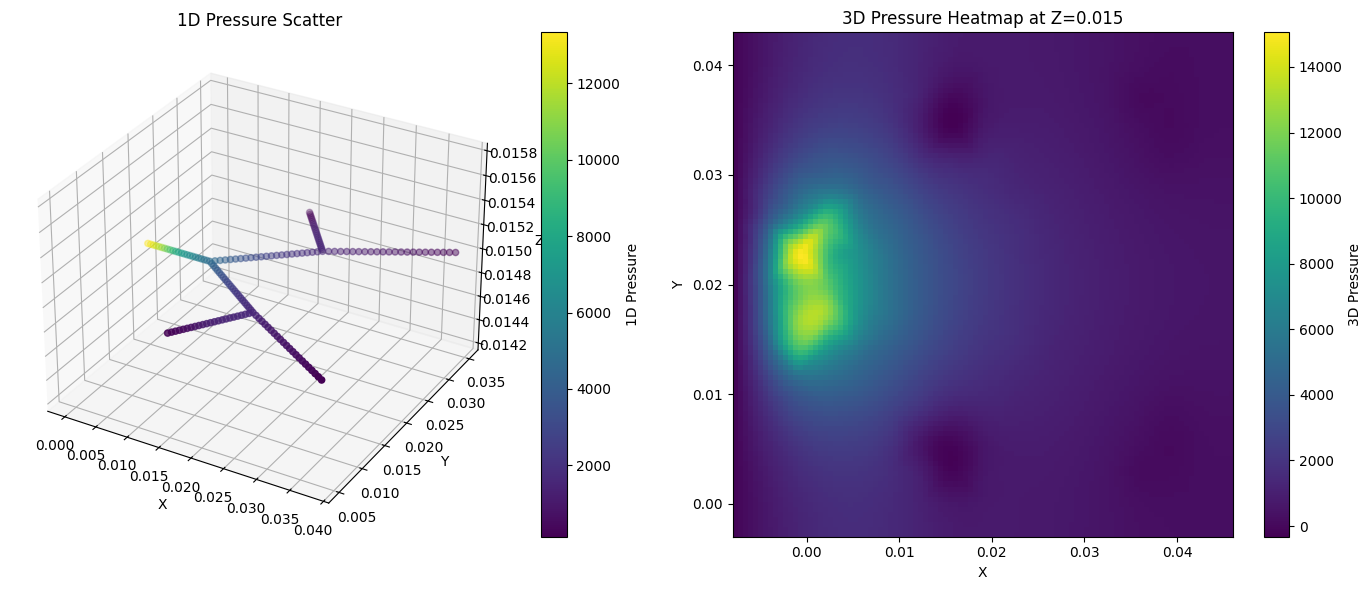

In [ ]:
Visualizer.plot(fem_test.uh1d, fem_test.uh3d)

Node Pressure Data:
Node 8: Pressure 12723.7
Node 9: Pressure 11979.0
Node 10: Pressure 10866.5
Node 11: Pressure 9578.3
Node 12: Pressure 8410.1
Node 13: Pressure 7413.6
Node 14: Pressure 6802.9
Node 15: Pressure 6288.3
Node 16: Pressure 5720.6
Node 17: Pressure 5212.0
Node 18: Pressure 4359.5
Node 19: Pressure 3938.8
Node 20: Pressure 3545.2
Node 21: Pressure 3179.9
Node 22: Pressure 2865.7
Node 23: Pressure 2570.5
Node 24: Pressure 2298.2
Node 25: Pressure 2057.6
Node 26: Pressure 1861.8
Node 27: Pressure 1723.3
Node 48: Pressure 1358.0
Node 49: Pressure 1195.6
Node 50: Pressure 1076.5
Node 51: Pressure 967.3
Node 52: Pressure 861.7
Node 53: Pressure 759.6
Node 54: Pressure 654.7
Node 55: Pressure 546.5
Node 56: Pressure 418.6
Node 57: Pressure 258.3


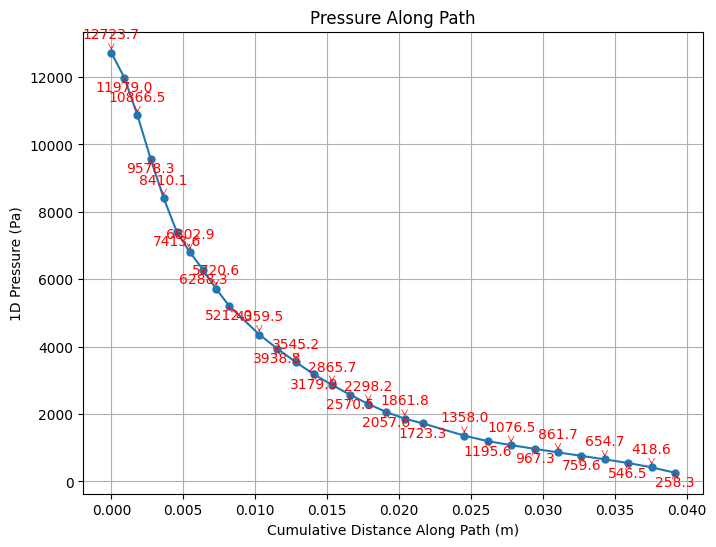

In [ ]:
Visualizer.plot_path_pressure(fem_test.uh1d, intermediate_nodes)

Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 793.89it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 503.25it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 570.66it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 751.73it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 783.42it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 821.30it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 459.54it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 759.61it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 797.79it/s]


Applied BC! Non-empty list
Iteration 1: parameters (log scale) = [-0.2    0.06   0.06   0.06  -7.994], cost = 3.1662565036122315e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 821.86it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 499.11it/s]


Applied BC! Non-empty list
Iteration 2: parameters (log scale) = [-0.2    0.06   0.06   0.06  -7.994], cost = 3.1662565036122315e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 503.91it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 796.90it/s]


Applied BC! Non-empty list
Iteration 3: parameters (log scale) = [-0.2    0.06   0.06   0.06  -7.994], cost = 3.1662565036122315e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 813.17it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 814.88it/s]


Applied BC! Non-empty list
Iteration 4: parameters (log scale) = [-0.2    0.06   0.06   0.06  -7.994], cost = 3.1662565036122315e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 502.23it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 826.34it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 839.58it/s]


Applied BC! Non-empty list
Iteration 5: parameters (log scale) = [-0.32928    0.061824   0.263424   0.119424  -8.0018816], cost = 3.1623950195381295e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 812.39it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 826.03it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 452.11it/s]


Applied BC! Non-empty list
Iteration 6: parameters (log scale) = [-0.526848    0.0989184   0.1614784   0.1910784  -8.00301056], cost = 3.156487686130434e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 837.91it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 817.33it/s]


Applied BC! Non-empty list
Iteration 7: parameters (log scale) = [-0.526848    0.0989184   0.1614784   0.1910784  -8.00301056], cost = 3.156487686130434e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 704.54it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 520.32it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 713.69it/s]


Applied BC! Non-empty list
Iteration 8: parameters (log scale) = [-0.77373952  0.26045722  0.31659162  0.10289562 -7.99413565], cost = 3.1479446723695016e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 715.90it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 811.74it/s]


Applied BC! Non-empty list
Iteration 9: parameters (log scale) = [-0.77373952  0.26045722  0.31659162  0.10289562 -7.99413565], cost = 3.1479446723695016e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 827.61it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 462.31it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 668.35it/s]


Applied BC! Non-empty list
Iteration 10: parameters (log scale) = [-1.30098452  0.24391056  0.62341162  0.34633258 -8.00296563], cost = 3.1140125866669186e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 698.74it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 712.89it/s]


Applied BC! Non-empty list
Iteration 11: parameters (log scale) = [-1.30098452  0.24391056  0.62341162  0.34633258 -8.00296563], cost = 3.1140125866669186e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 466.10it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 619.72it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 716.08it/s]


Applied BC! Non-empty list
Iteration 12: parameters (log scale) = [-1.83011702  0.58395941  0.62357137  0.47485032 -8.00644821], cost = 3.0479128281790256e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 721.92it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 752.29it/s]


Applied BC! Non-empty list
Iteration 13: parameters (log scale) = [-1.83011702  0.58395941  0.62357137  0.47485032 -8.00644821], cost = 3.0479128281790256e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 451.22it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 782.48it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 767.41it/s]


Applied BC! Non-empty list
Iteration 14: parameters (log scale) = [-2.63736809  0.76972978  1.03698065  0.45934374 -8.00661489], cost = 2.8006241473084716e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 759.76it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 485.63it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 747.97it/s]


Applied BC! Non-empty list
Iteration 15: parameters (log scale) = [-3.71833716  0.89318895  1.39912762  0.96663336 -8.01251838], cost = 2.013757933353928e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 803.51it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 802.03it/s]


Applied BC! Non-empty list
Iteration 16: parameters (log scale) = [-3.71833716  0.89318895  1.39912762  0.96663336 -8.01251838], cost = 2.013757933353928e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 688.73it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 487.02it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 774.23it/s]


Applied BC! Non-empty list
Iteration 17: parameters (log scale) = [-5.39450238  1.73064656  1.85793472  1.14649369 -8.01466847], cost = 3.1276666174683625e-10


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 727.60it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 819.39it/s]


Applied BC! Non-empty list
Iteration 18: parameters (log scale) = [-5.39450238  1.73064656  1.85793472  1.14649369 -8.01466847], cost = 3.1276666174683625e-10


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 407.27it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 813.79it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 753.55it/s]


Applied BC! Non-empty list
Iteration 19: parameters (log scale) = [-8.3552589   2.31320837  3.2390998   1.73981365 -8.03482379], cost = 2.5344723478637575e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 774.20it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 821.83it/s]


Applied BC! Non-empty list
Iteration 20: parameters (log scale) = [-8.3552589   2.31320837  3.2390998   1.73981365 -8.03482379], cost = 2.5344723478637575e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 435.08it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 717.32it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 775.36it/s]


Applied BC! Non-empty list
Iteration 21: parameters (log scale) = [-11.39175716   3.25140145   3.89985721   2.55511643  -8.04495286], cost = 2.500031650164773e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 817.85it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 549.34it/s]


Applied BC! Non-empty list
Iteration 22: parameters (log scale) = [-11.39175716   3.25140145   3.89985721   2.55511643  -8.04495286], cost = 2.500031650164773e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 830.10it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 704.82it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 814.00it/s]


Applied BC! Non-empty list
Iteration 23: parameters (log scale) = [-16.61304127   4.83804324   5.93958682   3.54038517  -8.05012746], cost = 2.5000000001901043e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 812.40it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 460.86it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 759.72it/s]


Applied BC! Non-empty list
Iteration 24: parameters (log scale) = [-22.45212584   6.16792194   8.2630152    4.95753714  -8.10154367], cost = 2.4999999999999607e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 807.07it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 780.48it/s]


Applied BC! Non-empty list
Iteration 25: parameters (log scale) = [-22.45212584   6.16792194   8.2630152    4.95753714  -8.10154367], cost = 2.4999999999999607e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 502.07it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 839.92it/s]


Applied BC! Non-empty list
Iteration 26: parameters (log scale) = [-22.45212584   6.16792194   8.2630152    4.95753714  -8.10154367], cost = 2.4999999999999607e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 750.70it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 717.42it/s]


Applied BC! Non-empty list
Iteration 27: parameters (log scale) = [-22.45212584   6.16792194   8.2630152    4.95753714  -8.10154367], cost = 2.4999999999999607e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 797.84it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 420.19it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 445.09it/s]


Applied BC! Non-empty list
Iteration 28: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.4999999999999565e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 808.60it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 779.86it/s]


Applied BC! Non-empty list
Iteration 29: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.4999999999999565e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 464.95it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 800.44it/s]


Applied BC! Non-empty list
Iteration 30: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.4999999999999565e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 713.88it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 834.83it/s]


Applied BC! Non-empty list
Iteration 31: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.4999999999999565e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 497.30it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 816.82it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 809.80it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 828.06it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 740.32it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 468.28it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 779.23it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 715.64it/s]


Applied BC! Non-empty list
Iteration 32: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.4999999999999565e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 811.54it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 475.87it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 814.29it/s]


Applied BC! Non-empty list
Iteration 33: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.4999999999999565e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 698.07it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 837.18it/s]


Applied BC! Non-empty list
Iteration 34: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.4999999999999565e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 758.29it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 447.95it/s]


Applied BC! Non-empty list
Iteration 35: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.4999999999999565e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 778.96it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 743.78it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 691.34it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 451.99it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 552.17it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 779.85it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 797.89it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 817.21it/s]


Applied BC! Non-empty list
Iteration 36: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.4999999999999565e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 489.12it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 800.52it/s]


Applied BC! Non-empty list
Iteration 37: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.4999999999999565e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 825.98it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 595.93it/s]


Applied BC! Non-empty list
Iteration 38: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.4999999999999565e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 809.89it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 407.13it/s]


Applied BC! Non-empty list
Iteration 39: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.4999999999999565e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 778.97it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 749.16it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 782.57it/s]


Applied BC! Non-empty list
Iteration 40: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.4999999999999565e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 508.51it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 724.95it/s]


Applied BC! Non-empty list
Iteration 41: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.4999999999999565e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 825.62it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 820.55it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 795.25it/s]


Applied BC! Non-empty list
Iteration 42: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.4999999999999565e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 547.40it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 809.08it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 809.19it/s]


Applied BC! Non-empty list
Iteration 43: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.4999999999999565e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 807.87it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 763.55it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 487.72it/s]


Applied BC! Non-empty list
Iteration 44: parameters (log scale) = [-43.78749355  12.33660209  15.99307935   9.28839868  -8.16014975], cost = 2.4999999999999555e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 816.25it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 785.30it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 702.17it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 474.75it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 807.89it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 805.29it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 806.39it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 773.73it/s]


Applied BC! Non-empty list
Iteration 45: parameters (log scale) = [-43.78749355  12.33660209  15.99307935   9.28839868  -8.16014975], cost = 2.4999999999999555e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 464.39it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 756.72it/s]


Applied BC! Non-empty list
Iteration 46: parameters (log scale) = [-43.78749355  12.33660209  15.99307935   9.28839868  -8.16014975], cost = 2.4999999999999555e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 783.92it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 816.58it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 521.53it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 447.39it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 805.05it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 787.83it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 815.82it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 509.31it/s]


Applied BC! Non-empty list
Iteration 47: parameters (log scale) = [-43.78749355  12.33660209  15.99307935   9.28839868  -8.16014975], cost = 2.4999999999999555e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 807.74it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 784.41it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 790.52it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 806.53it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 446.07it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 797.46it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 723.29it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 777.10it/s]


Applied BC! Non-empty list
Iteration 48: parameters (log scale) = [-43.78749355  12.33660209  15.99307935   9.28839868  -8.16014975], cost = 2.4999999999999555e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 717.90it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 449.43it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 399.91it/s]


Applied BC! Non-empty list
Iteration 49: parameters (log scale) = [-43.78749355  12.33660209  15.99307935   9.28839868  -8.16014975], cost = 2.4999999999999555e-11


<ipython-input-60-8805a12eb8fb>:70: RuntimeWarning: Maximum number of iterations has been exceeded.
  result = minimize(
Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 740.06it/s]


Applied BC! Non-empty list


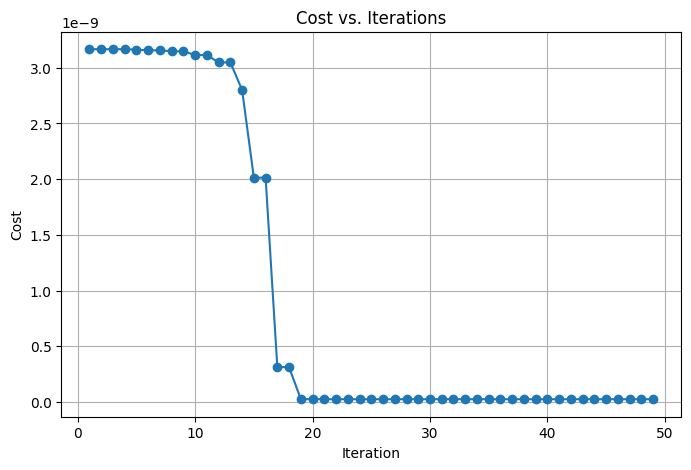

Optimization successful? False
Status code: 2
Message: Maximum number of iterations has been exceeded.
Number of iterations: 50
Final cost: 2.4999999999999555e-11
gamma    = 1.631e-44
gamma_R  = 2.171e+12
gamma_a  = 9.842e+15
gamma_v  = 1.943e+09
k_v      = 6.916e-09
flow     = 4.453e-20


In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def black_box_flow(gamma, gamma_R, gamma_a, gamma_v, k_v):
    fem_test = FEMSinkVelo.FEMSinkVelo(
        G=G,
        gamma=gamma,
        gamma_R=gamma_R,
        gamma_a=gamma_a,
        gamma_v=gamma_v,
        mu=1.0e-3,
        k_t=1.0e-10,
        k_v=k_v,
        P_in=100.0*133.322,
        p_cvp=1.0*133.322,
        Lambda_inlet=[0],
        Lambda_padding_min=0.008
    )
    flow_val = fem_test.compute_outflow_sink()
    return flow_val

def cost_function_log(params_log, target_flow):
    # Unpack parameters in log-space and convert to linear scale
    gamma_linear   = 10.0**(params_log[0])
    gamma_R_linear = 10.0**(params_log[1])
    gamma_a_linear = 10.0**(params_log[2])
    gamma_v_linear = 10.0**(params_log[3])
    k_v_linear     = 10.0**(params_log[4])

    # Evaluate the flow from the PDE solver
    flow_val = black_box_flow(
        gamma_linear,
        gamma_R_linear,
        gamma_a_linear,
        gamma_v_linear,
        k_v=k_v_linear
    )

    # Least-squares difference from the target flow
    return (flow_val - target_flow)**2

def multi_param_fit(
    target_flow=500.6,
    initial_guess_log=None,
    max_iter=50
):
    if initial_guess_log is None:
        initial_guess_log = [0.0, 0.0, 0.0, 0.0, -8.0]

    n_params = len(initial_guess_log)
    initial_simplex = [np.array(initial_guess_log)]
    for i in range(n_params):
        vertex = np.array(initial_guess_log, copy=True)
        if i == 4:  # k_v dimension: smaller step size
            vertex[i] += 0.01
        else:
            vertex[i] += 0.1
        initial_simplex.append(vertex)
    initial_simplex = np.array(initial_simplex)

    cost_history = []

    def callback(xk):
        cost = cost_function_log(xk, target_flow=target_flow)
        cost_history.append(cost)
        iteration_num = len(cost_history)
        print(f"Iteration {iteration_num}: parameters (log scale) = {xk}, cost = {cost}")

    result = minimize(
        fun=lambda p: cost_function_log(p, target_flow=target_flow),
        x0=np.array(initial_guess_log),
        method='Nelder-Mead',
        callback=callback,
        options={
            'maxiter': max_iter,
            'disp': True,
            'initial_simplex': initial_simplex
        }
    )

    best_log = result.x
    gamma_opt   = 10.0**(best_log[0])
    gammaR_opt  = 10.0**(best_log[1])
    gammaA_opt  = 10.0**(best_log[2])
    gammaV_opt  = 10.0**(best_log[3])
    k_v_opt     = 10.0**(best_log[4])

    flow_final = black_box_flow(gamma_opt, gammaR_opt, gammaA_opt, gammaV_opt, k_v_opt)

    # Plot the cost history
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cost_history) + 1), cost_history, marker='o', linestyle='-')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.title('Cost vs. Iterations')
    plt.grid(True)
    plt.show()

    return {
        'success': result.success,
        'status': result.status,
        'message': result.message,
        'n_iters': result.nit,
        'cost_final': result.fun,
        'gamma':   gamma_opt,
        'gamma_R': gammaR_opt,
        'gamma_a': gammaA_opt,
        'gamma_v': gammaV_opt,
        'k_v':     k_v_opt,
        'flow_final': flow_final,
        'cost_history': cost_history
    }

res = multi_param_fit(target_flow=5.0e-6, max_iter=50)

print("Optimization successful?", res['success'])
print("Status code:", res['status'])
print("Message:", res['message'])
print("Number of iterations:", res['n_iters'])
print("Final cost:", res['cost_final'])
print(f"gamma    = {res['gamma']:8.4g}")
print(f"gamma_R  = {res['gamma_R']:8.4g}")
print(f"gamma_a  = {res['gamma_a']:8.4g}")
print(f"gamma_v  = {res['gamma_v']:8.4g}")
print(f"k_v      = {res['k_v']:8.4g}")
print(f"flow     = {res['flow_final']:8.4g}")

In [ ]:
fem_test.save_vtk(os.path.join(WD_PATH, "perfusion_results", "25test3"))